In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Lecture 04

## Implementation of Neural Network
- One hidden layer
- Tanh Activation
- Moons dataset

<img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align = "left"/>

## 1. Import Statements

In [2]:
###-----------------
### Import Libraries
###-----------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import datasets
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
%matplotlib inline

## 2. Setup Global Parameters

In [3]:
###----------------
### Some parameters
###----------------

# Directory locations
inpDir = '../../input'
outDir = '../output'

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.2
EPOCHS = 10000  # number of epochs
ALPHA = 0.1  # learning rate
N_SAMPLES = 1000
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## 3. Generate Data Set
<div style="font-family: Arial; font-size:1.2em;color:black;">
Sklearn's dataset generator is good source of data for learning. To keep the example simple, I'll suggest  <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a> dataset generator.
</div>

In [4]:
X, y = datasets.make_moons(n_samples=N_SAMPLES, 
                           shuffle=True, 
                           noise=NOISE, 
                           random_state=RANDOM_STATE)
X.shape, y.shape

((1000, 2), (1000,))

## 4. Visualization
<p style="font-family: Arial; font-size:1.2em;color:black;">
DataFrames are easier to visualize
</p>

In [5]:
data_df = pd.DataFrame(X, columns=['A', 'B'])
data_df['target'] = y
data_df.head()

,A,B,target
0,0.906340,0.902676,0
1,-1.115368,0.755793,0
2,1.887692,0.417597,1
3,-0.933450,-0.022999,0
4,-0.968729,0.063963,0


In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       1000 non-null   float64
 1   B       1000 non-null   float64
 2   target  1000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 23.6 KB


In [7]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
A,1000.0,0.490841,0.898951,-1.688795,-0.149565,0.500100,1.095048,2.419113
B,1000.0,0.239025,0.540082,-0.955280,-0.205090,0.241163,0.680394,1.612075
target,1000.0,0.500000,0.500250,0.000000,0.000000,0.500000,1.000000,1.000000


In [8]:
data_df['target'].unique()

array([0, 1])

### 4.1 Different ways of plotting data

<Axes: xlabel='A', ylabel='B'>

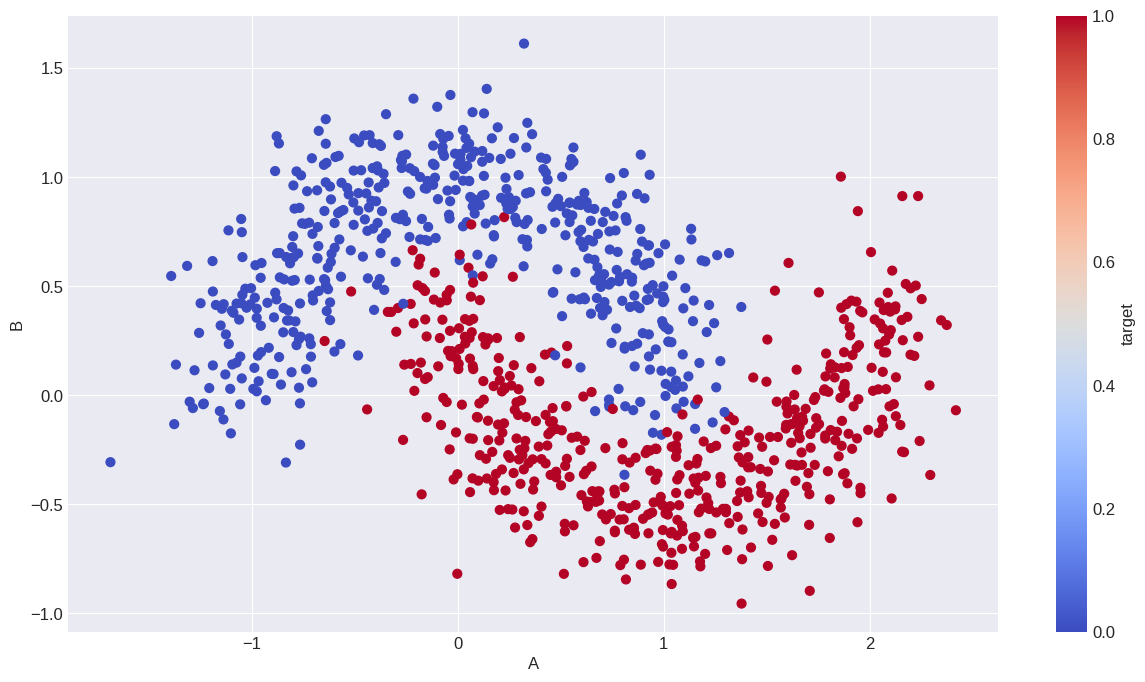

In [9]:
data_df.plot.scatter('A', 'B', s=40, c = 'target', cmap = CMAP)

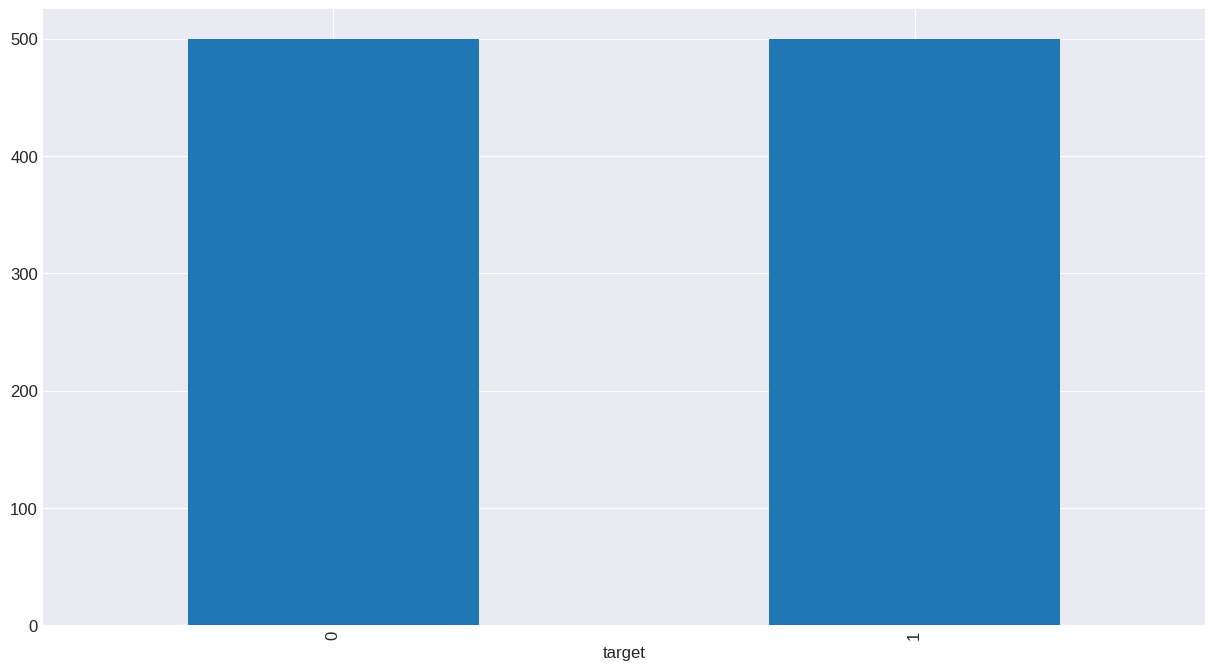

In [10]:
data_df['target'].value_counts().plot(kind = 'bar');

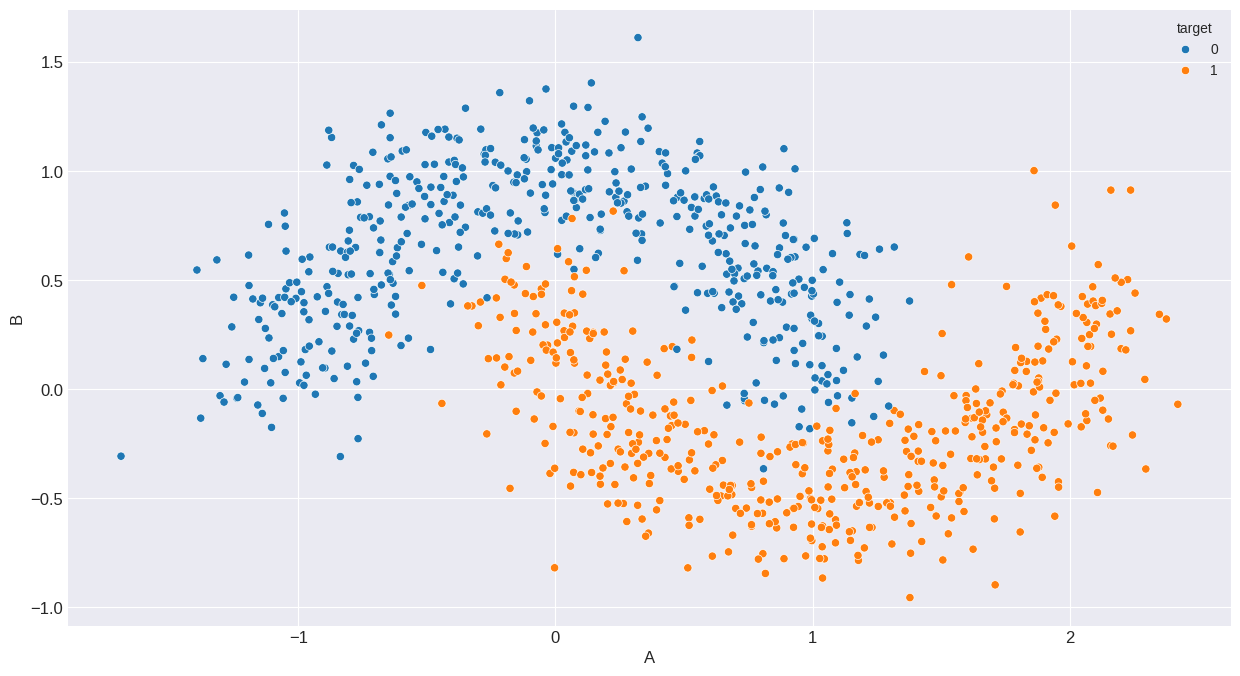

In [11]:
sns.scatterplot(x ='A', y='B', data = data_df, hue = 'target');

<div style="font-family: Arial; font-size:1.2em;">
    We will keep 10%, i.e. 100 records for testing and remaining records will be used in training. Note that the data is already random.
</div>

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=TEST_SIZE,
                                                    stratify=y, 
                                                    random_state=RANDOM_STATE)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800,), (200,))

# Over to Perceptron

## Sigmoid Function

In [13]:
def fn_sigmoid(z):

    return 1/(1+np.exp(-z))

In [14]:
fn_sigmoid(np.array([-np.inf, 0, 0.5, 1, np.inf]))

array([0.        , 0.5       , 0.62245933, 0.73105858, 1.        ])

## Tanh Activation Function

In [15]:
def fn_actv(z):
    return np.tanh(z)


def fn_actv_prime(a):
    return 1- np.tanh(a)**2


In [16]:
fn_actv(np.array([[-1, 0, 1], [-np.inf, 0, np.inf]]))

array([[-0.76159416,  0.        ,  0.76159416],
       [-1.        ,  0.        ,  1.        ]])

In [17]:
np.tanh(0.5)

0.46211715726000974

In [18]:
(1- np.power(np.tanh(0.5), 2))

0.7864477329659274

In [19]:
fn_actv_prime(0.5)

0.7864477329659274

## 5. Prediction

In [20]:
# A function to make predictions

def predict(model, X):

    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
        

    ####--------------------
    #### Forward Propagation
    ####--------------------

    # Layer 1
    z1 = X.dot(W1) + b1 # Agg
    a1 = fn_actv(z1)   # Activation

    # Layer 2
    z2 = a1.dot(W2) + b2 # Agg
    a2 = fn_sigmoid(z2)   # Activation

    
    return a2 >= 0.5

In [21]:
def calculate_loss (model, X, y):
    
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
        
    m = X.shape[0]
    
    ####--------------------
    #### Forward Propagation
    ####--------------------

    # Layer 1
    z1 = X.dot(W1) + b1 # Agg
    a1 = fn_actv(z1)   # Activation

    # Layer 2
    z2 = a1.dot(W2) + b2 # Agg
    a2 = fn_sigmoid(z2)   # Activation

    data_loss = -(y*np.log(a2)).sum()

    return 1./m * data_loss

In [22]:
# Function to train the model

def build_model (X, y, alpha = ALPHA, epochs = EPOCHS):

    W1 = np.random.rand(nn_input_dim, nn_hdim)/np.sqrt(nn_input_dim)
    W2 = np.random.rand(nn_hdim, nn_output_dim)/np.sqrt(nn_hdim)

    b1 = np.zeros((1, nn_hdim))
    b2 = np.zeros((1, nn_output_dim))

    curr_loss = 0

    loss, epoch =[], []

    m = X.shape[0]

    for i in range(epochs):

        ####--------------------
        #### Forward Propagation
        ####--------------------

        # Layer 1
        z1 = X.dot(W1) + b1 # Agg
        a1 = fn_actv(z1)   # Activation

        # Layer 2
        z2 = a1.dot(W2) + b2 # Agg
        a2 = fn_sigmoid(z2)   # Activation

        ####--------------------
        #### Back Propagation
        ####--------------------

        # Layer 2
        dz2 = a2 - y
        assert(z2.shape == dz2.shape), f'error z2 {z2.shape}/{dz2.shape}'
        
        dW2 = (a1.T).dot(dz2)
        assert(W2.shape == dW2.shape), f'error W2 {W2.shape}/{dW2.shape}'
        
        db2 = np.sum(dz2, axis = 0, keepdims=True)
        assert(b2.shape == db2.shape), f'error b2 {b2.shape}/{db2.shape}'

        da1 = dz2.dot(W2.T)

        # Layer 1
        dz1 = da1 * fn_actv_prime(z1)
        
        dW1 = (X.T).dot(dz1)
        assert(W1.shape == dW1.shape), f'error W1 {W1.shape}/{dW1.shape}'
        
        db1 = np.sum(dz1, axis = 0, keepdims=True)
        assert(b1.shape == db1.shape), f'error b1 {b1.shape}/{db1.shape}'

        W1 += - alpha * dW1 / m # gradient update
        W2 += - alpha * dW2 / m # gradient update
        b1 += - alpha * db1 / m # gradient update
        b2 += - alpha * db2 / m # gradient update

        model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

        if i%100 == 0:
            curr_loss = calculate_loss(model, X, y)
            loss.append(curr_loss)
            epoch.append(i)
            print(f'epoch: {i}; Current Loss = {curr_loss : .4f}')

    
    hist['loss'] = loss
    hist['epoch'] = epoch
    
    return model

In [23]:
nn_input_dim = X_train.shape[1]
nn_hdim = 4
nn_output_dim = 1

hist = {}

In [24]:
y_train = y_train.reshape(-1,1)
y_train.shape

(800, 1)

In [25]:
model = build_model (X_train, y_train)

epoch: 0; Current Loss =  0.3055
epoch: 100; Current Loss =  0.2568
epoch: 200; Current Loss =  0.1963
epoch: 300; Current Loss =  0.1635
epoch: 400; Current Loss =  0.1528
epoch: 500; Current Loss =  0.1492
epoch: 600; Current Loss =  0.1470
epoch: 700; Current Loss =  0.1446
epoch: 800; Current Loss =  0.1417
epoch: 900; Current Loss =  0.1380
epoch: 1000; Current Loss =  0.1335
epoch: 1100; Current Loss =  0.1285
epoch: 1200; Current Loss =  0.1233
epoch: 1300; Current Loss =  0.1181
epoch: 1400; Current Loss =  0.1131
epoch: 1500; Current Loss =  0.1084
epoch: 1600; Current Loss =  0.1040
epoch: 1700; Current Loss =  0.1000
epoch: 1800; Current Loss =  0.0962
epoch: 1900; Current Loss =  0.0927
epoch: 2000; Current Loss =  0.0894
epoch: 2100; Current Loss =  0.0863
epoch: 2200; Current Loss =  0.0833
epoch: 2300; Current Loss =  0.0803
epoch: 2400; Current Loss =  0.0774
epoch: 2500; Current Loss =  0.0744
epoch: 2600; Current Loss =  0.0714
epoch: 2700; Current Loss =  0.0685
epoc

<Axes: xlabel='epoch'>

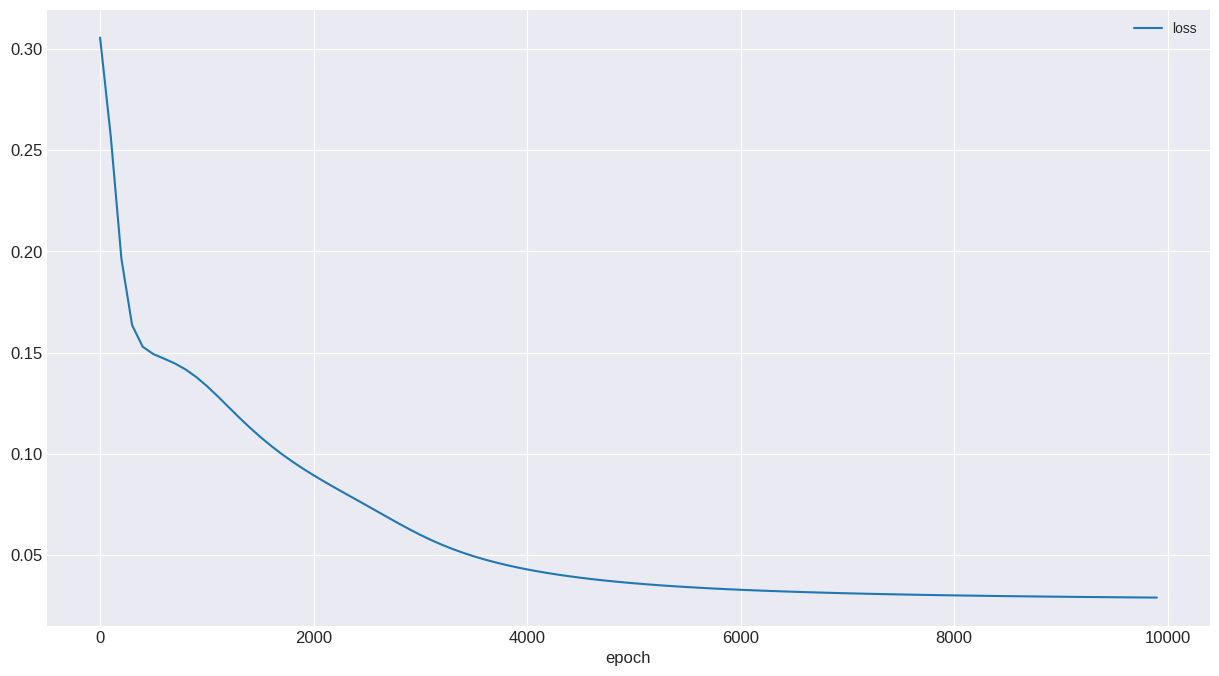

In [26]:
pd.DataFrame(hist).plot(x = 'epoch')

In [27]:
model

{'W1': array([[ 2.91292296,  1.04997537,  3.59684279,  3.14153665],
        [-1.38243701, -0.7722428 ,  3.08996819, -1.17370331]]),
 'b1': array([[-3.75187066,  0.88000385, -2.33102131,  1.63207776]]),
 'W2': array([[ 6.157214  ],
        [ 2.51121114],
        [-6.3595762 ],
        [ 4.66817439]]),
 'b2': array([[-0.50983511]])}

In [28]:
###-----------------------------------
### Function to plot Decision boundary
###-----------------------------------

def fn_plot_decision_boundary(pred_func, X_tr, y_tr, X_ts, y_ts):
    '''
        Attrib:
           pred_func : function based on predict method of the classifier
           X_tr : train feature matrix
           y_tr : train labels
           X_ts : test feature matrix
           y_ts : test labels
       Return:
           None
    '''
    
    # Set min and max values and give it some padding
    xMin, xMax = X_tr[:, 0].min() - .05, X_tr[:, 0].max() + .05
    yMin, yMax = X_tr[:, 1].min() - .05, X_tr[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.01
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    
    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    ax = fig.add_axes(111)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    ax.contourf(xx, yy, Z, cmap=CMAP) #, alpha = 0.8
    
    # Plotting scatter for train data
    ax.scatter(X_tr[:, 0], X_tr[:, 1], c=y_tr,
                                  s=30, edgecolor='k', cmap=plt.cm.coolwarm)
    
    
    # Plotting scatter for test data
    ax.scatter(X_ts[:, 0], X_ts[:, 1], c=y_ts,
                                  s=150, marker = '*',edgecolor='k', cmap=plt.cm.inferno )

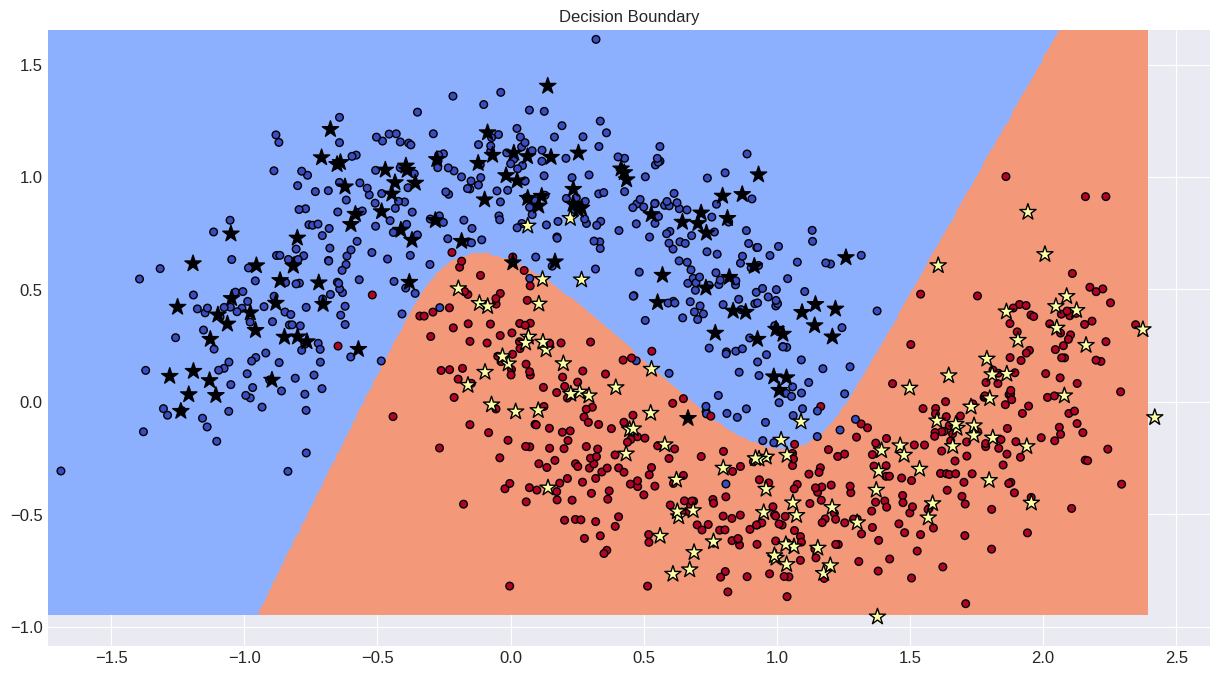

In [29]:
fn_plot_decision_boundary(lambda x: predict(model, x), X_train, y_train, X_test, y_test) # plot decision boundary for this plot

plt.title("Decision Boundary");

## Question
<div style="font-family: Arial; font-size:1.2em;">
Why do we keep training and not stop at min training error? Hold on! We would get to that eventually.
</div>

## 7. Predictions

### Train Set

### Test Set

In [ ]:
predictions =[] # list

for row in data_test: # iterate ove all rows
    
    prediction = predict(row, weights) # make prediction
    
    if prediction > 0.5:
        y_pred = 1
    else:
        y_pred = 0
    
    predictions.append(y_pred) # collect them in a list

In [ ]:
accuracy_score(data_test[:, -1], predictions) # calculate accuracy

In [ ]:
cm  = confusion_matrix(data_test[:, -1], predictions) # calculate accuracy)
cm

In [ ]:
fig, ax = plt.subplots (figsize=(6,6))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

disp.plot(ax = ax, cmap ='Blues', colorbar=False)

plt.grid()

In [ ]:
def fn_plot_decision_boundary(X: np.ndarray):
    
    # initialize the figure
    fig, ax = plt.subplots(figsize = (8,5));
    
    # Small increment to create object function surface
    dm = 0.05
    
    # Range of X values (First feature)
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    
    # Range of Y values (Second feature)
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    # Create a grid to evaluate the object function
    xx, yy = np.meshgrid(np.arange(x_min, x_max, dm),
                         np.arange(y_min, y_max, dm))
    
    # flatten and stack
    # arrays will be stacked along their last axis after being upgraded to at least 2-D 
    # with 1’s post-pended to the shape (column vectors made out of 1-D arrays)
    XX = np.c_[xx.ravel(), yy.ravel()] 

    # add another column filled with 1 to make it work with the predict function
    XX = np.hstack( ( XX, np.ones((XX.shape[0],1)) ) )
    
    # list to collect predictions
    y_pred = []
    
    # Iterate over rows
    for row in (XX):
        ## Changes for sigmoid
        pred = predict(row, weights)

        y_p = 0
        
        if pred >= 0.5:
            y_p = 1

        y_pred.append(y_p)
        
    Z = np.array(y_pred).reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.6, cmap=plt.cm.Paired)
    ax.scatter(X[:, 0], X[:, 1], c=X[:, 2],
                                  s=20, edgecolor='k', cmap=plt.cm.bwr)
    ax.set_title('Decision Boundary')

    ax.set_xlabel('A')
    ax.set_ylabel('B')
    plt.show()

In [ ]:
fn_plot_decision_boundary(data_train)

## Tracking
<div style="font-family: Arial; font-size:1.2em;color:black;">
Lets track the results across various implementations...

 |#|Implementation|Training Accuracy|Testing Accuracy|Remarks|
 |:-:|---|---|---|---|
 |1|Simple Perceptron|0.83111|0.89000||

## Notes:
<img src="../../images/dnn_nb_s03_fig1.png" width='350' align = 'left'>
<img src="../../images/dnn_nb_s03_fig2.png" width='550' align = 'right'>

## A note on Loss Function
<div style="font-family: Arial; font-size:1.2em;">
    <p>In logistic regression we are looking for if it is correct class or not. </p> 
    <p>For example, we want to know if there is a car in the picture or not. So the output is probability of a car in the picture.</p>
    <p><b>Mathematically speaking:</b></p>
    <p>$\hat{y} = p(y=1|x)$ i.e. given training sample $x$, we want to know probability of $y$ being 1.</p>
    <br>
    <p><b>Alternatively:</b></p>
    <p>If there is a car in the picture.  $\Rightarrow$  $y$ = 1 then $p(y|x)$ = $\hat{y}$.</p>
    <p>If there is <b>no</b> car in the picture.$\Rightarrow$ $y$ = 0 then $p(y|x)$ = 1 - $\hat{y}$.</p>
    <br>
    <p>We can summarize two equations as: $p(y|x)$ = $\hat{y}^{y} * (1 - \hat{y}) ^{(1-y)}$</p>
    <p>Above equation is $\hat{y}$ for y = 1 and (1 - $\hat{y}$) for y = 0.</p>
    <p>Taking log of above equation:</p>

$
\begin{aligned}
log [ p(y|x) ] & = log[\hat{y}^{y} * (1 - \hat{y}) ^{(1-y)}]\\
& = y * log(\hat{y}) + (1-y) * log(1 - \hat{y})\\
\end{aligned}
$
<p>Since we aim to minimize above function, add negative sign and our loss function becomes</p>

$
\begin{aligned}
L(\hat{y},y) =  -[y * log\hat{y} + (1-y) * log(1-\hat{y})]\\
\text{or}\\
L(a,y) =  - [ y * log ( a ) + ( 1 - y ) * log( 1 - a ) ]\\
\end{aligned}
$

|Case| y |Loss| a |-log(a)|-log(1-a)|
|:-: |:-:|:-: |:-:|  :-: |   :-:  |
| 1  | 0 | -log( 1 - a )| 0.000001 |13.8155|**1 e-6**|
| 2  | 0 | -log( 1 - a )| 0.999999 |1 e-6|**13.8155**|
| 3  | 1 | -log( a )| 0.000001 |**13.8155**|1 e-6|
| 4  | 1 | -log( a )| 0.999999 |**1 e-6**|13.8155|

</div>

<div style="font-family: Arial; font-size:1.2em;">
    <p>For binary classification the error = - $y * log(a)$</p>
    <p>We want to sum it up for all samples in the dataset. Hence:</p>

$
\begin{aligned}
p(\text{all ys | all rows of x}) & =  \Pi_{i=0}^m p(y|x)\\
log [ p(\text{all ys | all rows of x})] & =  log [ \Pi_{i=0}^m p(y|x) ]\\
& =  \sum_{i=0}^m log [ p(y|x) ] \\
& =  \sum_{i=0}^m [ y * log(\hat{y}) + (1-y) * log(1 - \hat{y}) ]\\
\text{Divide it by m to better scale the costs}\\
& = \frac{1}{m} * \sum_{i=0}^m [ y * log(\hat{y}) + (1-y) * log(1 - \hat{y}) ]\\
\end{aligned}
$

### Introducing $\mathrm{sigmoid}$ function for our binary output.
$$
\begin{aligned}
z & = x_1 . w_1 + x_2 . w_2 + b_1 \\
a & = \hat{y} = \sigma(z)\\
dz & = (a - y) \\
db & = dz\\
b & = b - \alpha . db\\
dw_1 & = x_1. dz\\
dw_2 & = x_2.dz\\
w_1 & = w_1 - \alpha . dw_1\\
w_2 & = w_1 - \alpha . dw_2\\
\end{aligned}
$$
### Sigmoid function
$$
\begin{align}
a &= \sigma(z)\\
&= \dfrac{1}{1 + e^{-z}}\\
\end{align}
$$
    <h3>Derivative of sigmoid function</h3>
$$
\begin{align}
\partial{a} &= \partial{(\sigma(z))}\\
&= \dfrac{\partial}{\partial{z}} \left[ \dfrac{1}{1 + e^{-z}} \right] \\
&= \dfrac{\partial}{\partial{z}} \left( 1 + \mathrm{e}^{-z} \right)^{-1} \\
&= -(1 + e^{-z})^{-2}(-e^{-z}) \\
&= \dfrac{e^{-z}}{\left(1 + e^{-z}\right)^2} \\
&= \dfrac{1}{1 + e^{-z}\ } \circ \dfrac{e^{-z}}{1 + e^{-z}}  \\
&= \dfrac{1}{1 + e^{-z}\ } \circ \dfrac{(1 + e^{-z}) - 1}{1 + e^{-z}}  \\
&= \dfrac{1}{1 + e^{-z}\ } \circ \left[ \dfrac{1 + e^{-z}}{1 + e^{-z}} - \dfrac{1}{1 + e^{-z}} \right] \\
&= \dfrac{1}{1 + e^{-z}\ } \circ \left[ 1 - \dfrac{1}{1 + e^{-z}} \right] \\
&= \sigma(z) \circ (1 - \sigma(z))\\
&= a \circ (1 - a)
\end{align}
$$
    </div>